In [31]:
# Import the quantum chemistry driver and related units
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

# Import the qubit mapper library for Ci+ and Ci
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper, BravyiKitaevSuperFastMapper

# Import a classical analyzer to compare results with VQE
from qiskit_algorithms import NumPyMinimumEigensolver

# Import VQE and related libraries
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, NELDER_MEAD, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

# Import ground state solver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# Numpy
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

In [9]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [10]:
# mapper = JordanWignerMapper()
mapper = BravyiKitaevMapper()

In [11]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(Estimator(), ansatz, NELDER_MEAD())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

In [12]:
ansatz.decompose().draw()

┌───┐┌───────────────────────────────┐┌───────────────────────────────┐»
q_0: ┤ X ├┤0                              ├┤0                              ├»
     ├───┤│                               ││                               │»
q_1: ┤ X ├┤1                              ├┤1                              ├»
     ├───┤│  exp(-it (IIIY + IIZY))(t[0]) ││  exp(-it (IYII + ZYZI))(t[1]) │»
q_2: ┤ X ├┤2                              ├┤2                              ├»
     └───┘│                               ││                               │»
q_3: ─────┤3                              ├┤3                              ├»
          └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                        ├
«     │                                                                         │
«q_1: ┤1                                                                        ├
«     │  exp(-it (ZXZY + IYZX + IXIY + ZYIX + IYIX + ZXIY + ZYZX + IXZY))(t[2]) │
«q_2: ┤2                                                                        ├
«     │                                                                         │
«q_3: ┤3                                                                        ├
«     └─────────────────────────────────────────────────────────────────────────┘

In [13]:
calc = GroundStateEigensolver(mapper, vqe_solver)

In [14]:
%%time
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275028293
  - computed part:      -1.857275028293
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306033844
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.389017800444]
    - computed part:      [0.0  0.0  1.389017800444]
  > Dipole moment (a.u.): [0.0  0.0  -0.000069100444]  Total: 0.000069100444
                 (debye): [0.0  0.0  -0.000175635794]  Total: 0.000175635794
 
CPU times: user 11.9 s, sys: 185 ms, total: 12.1 s
Wall time: 12.2 s


### Comparing with a classical Eigensolver (provided by numpy)

In [15]:
numpy_solver = NumPyMinimumEigensolver()
calc2 = GroundStateEigensolver(mapper, numpy_solver)

In [16]:
%%time
res2 = calc2.solve(es_problem)
print(res2)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 
CPU times: user 192 ms, sys: 27 ms, total: 219 ms
Wall time: 225 ms


### Measuring performance of UCCSD with various interactomic distance

In [81]:
# molecule = "H .0 .0 -{0}; H .0 .0 {0}"
molecule = "H .0 .0 .0; H .0 .0 {0}"
delta = 0.025
steps = 20
start = 0.5
energies = np.empty(steps + 1)
hf_energies = np.empty(steps + 1)
np_energies = np.empty(steps + 1)
distances = np.empty(steps + 1)

In [83]:
def run_simulation(dist):
    print("\tMolecule: {}", molecule.format(dist))
    driver = PySCFDriver(
        atom=molecule.format(dist),
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    
    return (vqe_simulation(problem), numpy_simulation(problem))

In [84]:
def numpy_simulation(problem):
    numpy_solver = NumPyMinimumEigensolver()
    calc = GroundStateEigensolver(mapper, numpy_solver)
    return calc.solve(problem)

In [85]:
def vqe_simulation(problem):
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
    
    solver = VQE(Estimator(), ansatz, NELDER_MEAD())
    solver.initial_point = [0.0] * ansatz.num_parameters
    calc = GroundStateEigensolver(mapper, vqe_solver)
    return calc.solve(problem)

In [87]:
for step in range(steps + 1):
    dist = start + (delta * step)
    distances[step] = dist       # For later use in plotting
    result1, result2 = run_simulation(dist)
    energies[step] = result1.total_energies
    hf_energies[step] = result1.hartree_fock_energy
    np_energies[step] = result2.total_energies
    print("Iteration: {}; Distance: {}; Energy: {}; Hartee-Fock: {}, NP Energy: {}".format(
        step, dist, energies[step], hf_energies[step], np_energies[step])
    )
    print("=" * 10)


	Molecule: {} H .0 .0 .0; H .0 .0 0.5


/var/folders/2n/gz75zbhd50d7m9pgjxyccxch0000gn/T/ipykernel_29485/2557122483.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[step] = result1.total_energies
/var/folders/2n/gz75zbhd50d7m9pgjxyccxch0000gn/T/ipykernel_29485/2557122483.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np_energies[step] = result2.total_energies


Iteration: 0; Distance: 0.5; Energy: -1.0551597919227416; Hartee-Fock: -1.042996274540095, NP Energy: -1.055159794470624
	Molecule: {} H .0 .0 .0; H .0 .0 0.525
Iteration: 1; Distance: 0.525; Energy: -1.0759136525760733; Hartee-Fock: -1.0630621429206075, NP Energy: -1.0759136551892536
	Molecule: {} H .0 .0 .0; H .0 .0 0.55
Iteration: 2; Distance: 0.55; Energy: -1.0926299049525694; Hartee-Fock: -1.0790507361774577, NP Energy: -1.0926299067451066
	Molecule: {} H .0 .0 .0; H .0 .0 0.575
Iteration: 3; Distance: 0.575; Energy: -1.1059180507095534; Hartee-Fock: -1.0915704967771855, NP Energy: -1.1059180532539967
	Molecule: {} H .0 .0 .0; H .0 .0 0.6
Iteration: 4; Distance: 0.6; Energy: -1.1162860045705936; Hartee-Fock: -1.1011282422677018, NP Energy: -1.116286006869537
	Molecule: {} H .0 .0 .0; H .0 .0 0.625
Iteration: 5; Distance: 0.625; Energy: -1.1241609185947763; Hartee-Fock: -1.1081499901921303, NP Energy: -1.1241609196298896
	Molecule: {} H .0 .0 .0; H .0 .0 0.65
Iteration: 6; Distance

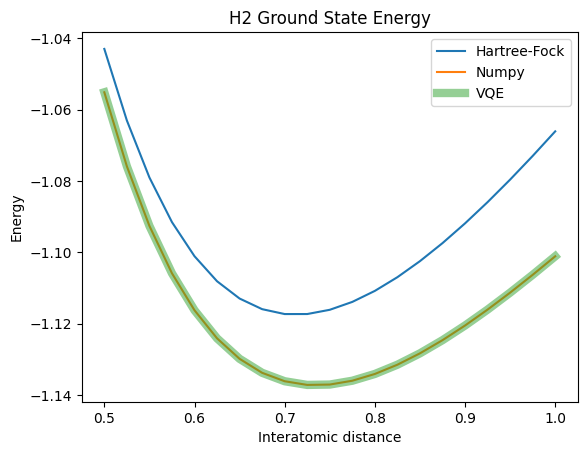

In [94]:
plt.plot(distances, hf_energies, label="Hartree-Fock")
plt.plot(distances, np_energies, label="Numpy")
plt.plot(distances, energies, label="VQE", alpha=0.5, linewidth=6) 
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.title('H2 Ground State Energy')
plt.legend(loc='upper right')
plt.show()

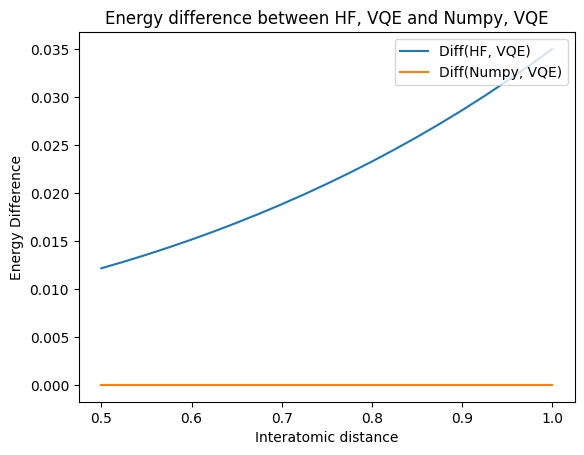

In [96]:
plt.plot(distances, np.subtract(hf_energies, energies), label="Diff(HF, VQE)")
plt.plot(distances, np.subtract(np_energies, energies), label="Diff(Numpy, VQE)")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy Difference")
plt.title("Energy difference between HF, VQE and Numpy, VQE")
plt.legend(loc="upper right")
plt.show()